# Compate VisitTables-visit PZ with predicted PZ in  OGA for Auxtel Fit

 work with Weakly_2023_44
- use jupyter kernel LSST
- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab
- creation date : 2024/01/02
- update : 2023/01/10


In [1]:
! eups list -s | grep LOCAL

analysis_tools        LOCAL:/home/d/dagoret/repos/repos_w_2023_44/analysis_tools 	setup
atmospec              LOCAL:/home/d/dagoret/repos/repos_w_2023_44/atmospec 	setup
eups                  LOCAL:/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/eups 	setup
spectractor           LOCAL:/home/d/dagoret/repos/repos_w_2023_44/Spectractor 	setup


In [2]:
! eups list -s lsst_distrib

   g4213664e8e+d053631def 	current w_2023_44 setup


In [3]:
import lsst.daf.butler as dafButler
#import lsst.summit.utils.butlerUtils as butlerUtils

In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm,SymLogNorm


import matplotlib.ticker                         # here's where the formatter is
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

from astropy.visualization import (MinMaxInterval, SqrtStretch,ZScaleInterval,PercentileInterval,
                                   ImageNormalize,imshow_norm)
from astropy.visualization.stretch import SinhStretch, LinearStretch,AsinhStretch,LogStretch

from astropy.io import fits

import pandas as pd

import matplotlib.ticker                         # here's where the formatter is
import os,sys
import re
import pandas as pd
import pickle

plt.rcParams["figure.figsize"] = (4,3)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'

In [5]:
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

from astropy.visualization import (MinMaxInterval, SqrtStretch,ZScaleInterval,PercentileInterval,
                                   ImageNormalize,imshow_norm)
from astropy.visualization.stretch import SinhStretch, LinearStretch,AsinhStretch,LogStretch

from astropy.time import Time


In [6]:
# LSST Display
import lsst.afw.display as afwDisplay
afwDisplay.setDefaultBackend('matplotlib')

In [7]:
transform = AsinhStretch() + PercentileInterval(99.)

In [8]:
pd.options.display.max_columns = None
#pd.options.display.max_rows = None

In [9]:
machine_name = os.uname().nodename
print(machine_name)
if 'sdf' in machine_name:
    #machine_name_usdf = 'sdfrome001'
    #machine_name_notebook platform = 'dagoret-nb'
    print("Set environement for USDF")
    newpythonpath = os.path.join(os.getenv("HOME"),"repos/repos_w_2023_44/rubinsimphot/src")
    sys.path.append(newpythonpath)
    newpythonpath = os.path.join(os.getenv("HOME"),"rubin-user/RubinLSSTPhotometricCorrTuto/notebooks/lib")
    sys.path.append(newpythonpath)   
elif "dagoret-nb" in machine_name:
    print("Set environement for Rubin Platform at  USDF")
    newpythonpath = os.path.join(os.getenv("HOME"),"repos/repos_w_2023_44/rubinsimphot/src")
    sys.path.append(newpythonpath)
    newpythonpath = os.path.join(os.getenv("HOME"),"rubin-user/RubinLSSTPhotometricCorrTuto/notebooks/lib")
    sys.path.append(newpythonpath)
elif 'mac' in machine_name:
    print("Be sure to run this notebook in conda environnement named conda_py310")
else:
    print("Your current machine name is {machine_name}. Check your python environment")

dagoret-nb
Set environement for Rubin Platform at  USDF


In [10]:
from libPhotometricCorrections_auxtel import *

LSST site name validated as LSST observatory


## Introduction and Review on Photometric corrections

- from https://github.com/sylvielsstfr/RubinLSSTPhotometricCorrTuto

### Reminder on what kind of flux we want to calculate 

- the Flux in each band $b$ at the TOP of atmosphere

$$
F_{b\;AB}^{std} = \frac{1}{F_{0}} \int \phi_{b}^{std}(\lambda) F_\nu({\lambda})d\lambda
$$

where:
- $F_{0}$ is a constant such as $F_0^{AB}=3631$ Jy with $1 Jy = 10^{-23} erg.cm^{-2}.s^{-1}.Hz^{-1}$,
- $F_\nu(\lambda)$ is the SED (Spectral Energy Distribution) of the object in Jansky unit. **In general $F_\nu(\lambda)$ is unknown or poorly known after identification/classification of the object,** 
- $\phi_{b}^{std}(\lambda)$ : is the standard normalised response of the telescope (including atmosphere and hardware electronics and optics):

$$
\phi^{std}_b(\lambda) = \frac{S_b^{std}(\lambda) \frac{1}{\lambda}}{\int S_b^{std}(\lambda) \frac{d \lambda}{\lambda}}
$$

- $S_b^{std}(\lambda)$ is **the defined** LSST survey total transmission of the instrument + atmosphere, taken to be the most probable or average or median total transmission:
$$
S_b^{std}(\lambda) = S^{std}_{atm}(\lambda) \times S_{b\; inst}^{std}(\lambda)
$$
It is defined at a particular airmass, a particular atmospheric transmission (with a set a pre-defined atmospheric parameters) and a particular hardware-optics+electronics setting.


Note if $F_{b\; AB}^{std}$ is a quantity that we have to calculate from the known $\phi_b^{std}$, the true SED $F_\nu$ is in principle unknown : we have
to measure something !
This is the per exposure ADC photometric count in band $b$: 
$$
ADC_b^{std} = \frac{A \Delta T}{g_{el}h} \int S_{b}^{std}(\lambda) F_\nu(\lambda) \frac{d\lambda}{\lambda}
$$

- $ADC_b^{std}$ is the expected number of counts, after correction from Instrument Signature Removal, including CCD unflattening and aperture photometry on the object.
- $A$, $\Delta T$, $g_{el}$ are the instrument constants, respectively Surface collection, Exposure-time, electronic gain . They are much poorely known at the percent level.
- $h$ is the Planck constant.

The point is that we never measure ADC counts with a  $S_{b}^{std}(\lambda)$ transmission. We measure $ADC_b^{obs}$ (after ISR and unflattening on the image and aperture photometry on the object) for each visit of the object
for a also measured transmission $S_{b}^{obs}(\lambda)$.

$$
ADC_b^{obs} = \frac{A \Delta T}{g_{el}h} \int S_{b}^{obs}(\lambda) F_\nu(\lambda) \frac{d\lambda}{\lambda}
$$

### Goal of Photometric Correction
**So the goal of Photometric correction is to calculate for each visit  the flux in the observed band $b$ : $F_{b\;AB}^{std}$ from the measured $ADC_b^{obs}$,
for a calibrated $S_b^{obs}(\lambda)$ or equivalently $\phi_b^{obs}(\lambda)$ given a defined $S_b^{std}(\lambda)$ or equivalently $\phi_b^{std}(\lambda)$.** 

After rearranging the above equation, one get the AB flux per visit in LSST standard band $b$:

$$
F_{b\; AB}^{std} = \frac{g_{el} h}{F_0 A \Delta T} \frac{ADU^{obs}_b}{\mathbb{I}_{0\,b}^{obs}} \frac{\int \phi_b^{std}(\lambda) F_\nu(\lambda) d\lambda}{\int \phi_b^{obs}(\lambda) F_\nu(\lambda) d\lambda}
$$

where the integral  $\mathbb{I}_{0\,b}^{obs}$ is defined as :
$$
\mathbb{I}_{0\,b}^{obs} = \int S_{b}^{obs}(\lambda) \frac{d\lambda}{\lambda} 
$$

- **The interpretation of $\mathbb{I}_{0\,b}^{obs}$ correspond to the calculation of an average attenuation in the $b$ band**.
This term compensates the variation of the band absorption measured $ADU_b^{obs}$, thus correcting at zeroth order $F_{b\; AB}^{std}$.

*Note if we don't know $S_b^{obs}(\lambda)$, we have to replace at zeros order the unknown integral  $\mathbb{I}_{0\,b}^{obs}$ by the known defined integral  $\mathbb{I}_{0\,b}^{std} = \int S_{b}^{std}(\lambda) \frac{d\lambda}{\lambda}$. However any variation of the absorption in the filter band $b$ would not be compensated.*

- The term of constants $\frac{g_{el} h}{F_0A \Delta T}$ is poorly known because we don't know these constants at the percent level (except $h$ and $F_0$). 
This term is referred as the instrumental zero point term. It is a calibration constant that must be determined by a dedicated Zero-point calibration procedure
for each visit, for each CCD from a series of calibration stars seen on the CCD plate. It is a kind of time dependent grey term to be applied band per band , CCD per CCD.

- The term $ \frac{\int \phi_b^{std}(\lambda) F_\nu(\lambda) d\lambda}{\int \phi_b^{obs}(\lambda) F_\nu(\lambda) d\lambda}$ refer explicitely to the unknown SED $F_\nu(\lambda)$. This is why one refer as the color term in the band $b$. This is term is expected to be colose to unity : 

- If observations conditions are close to standard condtions, this term is close to 1. 
- If the SED shape is close to that of a flat source, like an ideal AB source, this term is close to 1. 

However,
- If the SED has a sharp slope in the band, this term may not be negligible compared to the expected photometric accuracy.

This term seems to generate a bias in the flux. But on the contrary, it could bring additionnal information, because
we could measure it with serveral visits per object:

The we could aim to guess $F_\nu(\lambda)$ shape from the measured average $< F_{b\; AB}^{std} >$ for that object.
By expanding the SED shape at first order in the $b$ band:
$$
F_\nu(\lambda) \simeq F_\nu(\lambda_b)\left(1 +  f^{\prime}(\lambda_b)(\lambda- \lambda_b)\right)
$$


$$
F_{b\; AB}^{std} = \frac{g_{el} h}{F_0A \Delta T} \frac{ADU^{obs}_b}{\mathbb{I}_{0\,b}^{obs}} 
\left(1 + f^{\prime}(\lambda_b)(\Pi_{1\,b}^{std} -  \Pi_{1\,b}^{obs}) \right)
$$

  Note the term $F_\nu(\lambda_b)$ is eliminated, only the relative derivative $f^\prime(\lambda_b) = \frac{1}{F_\nu(\lambda_b)}\frac{dF\nu}{d\lambda}(\lambda_b)$ matters.

The standard magnitude per visit reads:

$$
m_{b\, AB}^{std} = -2.5 \log_{10}(ADU^{obs}_b) + 2.5 \log_{10} \frac{\Pi_{0\,b}^{obs}}{\Pi_{0\,b}^{std}} + \frac{2.5}{\ln(10)}f^{\prime}(\lambda_b)(\Pi_{1\,b}^{std} -  \Pi_{1\,b}^{obs}) + ZPT_b
$$


- $-2.5 \log_{10}(ADU^{obs}_b)$ is the instrumental magnitude,
- $2.5 \log_{10} \frac{\Pi_{0\,b}^{obs}}{\Pi_{0\,b}^{std}}$ is the zeros-th order correction for band relative attenuation (compared to standard attenuation),
- $\frac{2.5}{\ln(10)}f^{\prime}(\lambda_b)(\Pi_{1\,b}^{std} -  \Pi_{1\,b}^{obs})$ is the first-order color term correction
- $ZPT_b =  2.5 \log_{10} \left(\frac{F_0 A \Delta T}{g_{el} h} \right)  + 2.5 \log_{10}(\Pi_{0\,b}^{std})$ is the source independent and transmission variation independent zero point that does not need to be calculated to be evaluated CCD per CCD, visit per visit using several photometric calibration sources in LSST FOV.
(This is a kind of band Zero point, because we add the term $2.5 \log_{10}(\Pi_{0\,b}^{std}$ to the pure instrumental term.) 

## Summary on Photometric correction goals

We propose to calibrate sources Fluxes in AB unit, by correcting instrumental magnitudes, band by band, visit per visit independently. 
We are able to separate the contribution of the atmoshere attenuation even if the SED is unknown.
For this calibration we requires to monitor the transmission integrals :

- $2.5 \log_{10} \frac{\Pi_{0\,b}^{obs}}{\Pi_{0\,b}^{std}}$ to correct magnitude at zeros-th order for any band-average grey attenuation,
- $(\Pi_{1\,b}^{std} -  \Pi_{1\,b}^{obs})$ to correct magnitude at first order for SED average slope in the band,
  
  
- In addition a method to derive the photometrical zero point ZPT must be studied in this DEC-PC group (this subject is not adressed for the moment),

- Aperture Photometric accuracy including sky background contribution in $-2.5 \log_{10}(ADU^{obs}_b)$ is still an open field in DESC-PC group.

## Simulation

In [11]:
all_am = np.linspace(1,2.5,16)
NAM=len(all_am)
am0=1.2
pwv0= 2.32
oz0 = 265.4
tau0 = 0.022
beta0 = 1.0

In [12]:
all_am_tags = []
for index,am in enumerate(all_am):
    am_tag = "am_"+str(int(am*10))
    all_am_tags.append(am_tag)
all_am_tags=np.array(all_am_tags)
all_am_tags

array(['am_10', 'am_11', 'am_12', 'am_13', 'am_14', 'am_15', 'am_16',
       'am_17', 'am_18', 'am_19', 'am_20', 'am_21', 'am_22', 'am_23',
       'am_24', 'am_25'], dtype='<U5')

### Compute the atmospheric simulations

In [13]:
pc = PhotometricCorrections(am0,pwv0,oz0,tau0,beta0)
pc.CalculateMultiObs(all_am,pwv0,oz0,tau0,beta0)

/home/d/dagoret/repos/repos_w_2023_44/rubinsimphot/src/rubinsimphot/phot_utils/bandpass.py:68: UserWarning: Wavelength sampling of 1.0 nm is > 0.2 nm, this may not work well with a Sed object. Consider resampling with resample_bandpass method.
  warnings.warn(


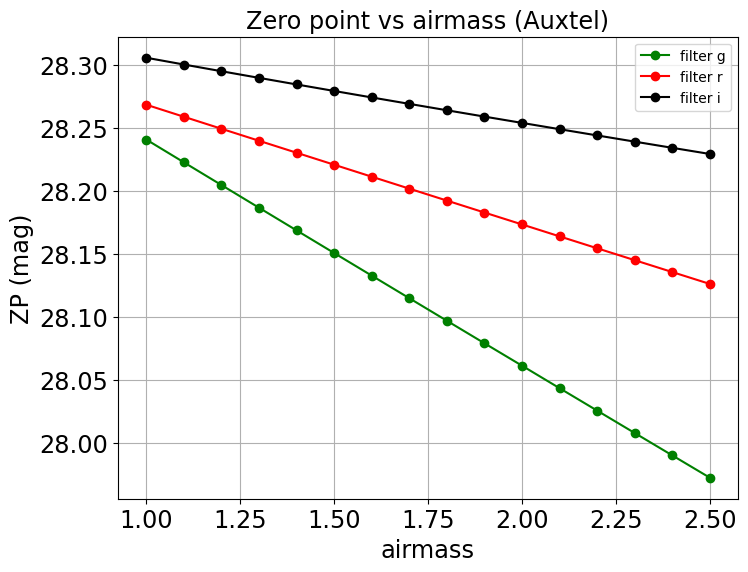

In [14]:
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.plot(all_am,pc.allcollperfilter['g']['ZPT_nonstd'],'o-g',label="filter g")
ax.plot(all_am,pc.allcollperfilter['r']['ZPT_nonstd'],'o-r',label="filter r")
ax.plot(all_am,pc.allcollperfilter['i']['ZPT_nonstd'],'o-k',label="filter i")
ax.set_title("Zero point vs airmass (Auxtel)")
ax.set_xlabel("airmass")
ax.set_ylabel("ZP (mag)")
ax.legend()
ax.grid()

## Configuration for Photometry

In [15]:
filesource_out="ccdVisitTable_202312.csv"
#filetractpatch_out = 'Latiss_tractspatchs_202312.pickle'

In [16]:
#repo =  "/sdf/group/rubin/repo/main"
repo = "/sdf/group/rubin/repo/oga/"
butler = dafButler.Butler(repo)
registry = butler.registry

In [17]:
def get_corners_radec(wcs, bbox):
    """
    Return the corners in RA,Dec in degrees given the WCS and bounding box for an image.

    Parameters
    ----------
    wcs: image WCS returned by the Butler
    bbox: bounding box returned by the Butler

    Returns
    -------
    corners_ra, corners_dec in decimal degrees
    """

    corners_x = [bbox.beginX, bbox.beginX, bbox.endX, bbox.endX]
    corners_y = [bbox.beginY, bbox.endY, bbox.endY, bbox.beginY]
    corners_ra = []
    corners_dec = []
    for i in range(4):
        radec = wcs.pixelToSky(corners_x[i], corners_y[i])
        corners_ra.append(radec.getRa().asDegrees())
        corners_dec.append(radec.getDec().asDegrees())
    
    return corners_ra, corners_dec

In [18]:
def get_bbox_radec(wcs, bbox):
    """
    Return the corners in RA,Dec in degrees given the WCS and bounding box for an image.

    Parameters
    ----------
    wcs: image WCS returned by the Butler
    bbox: bounding box returned by the Butler

    Returns
    -------
    ramin,ramax,decmin,decmax in decimal degrees
    """

    xmin = bbox.beginX
    xmax = bbox.endX
    ymin = bbox.beginY
    ymax = bbox.endY
    
    radec_ll = wcs.pixelToSky(xmin, ymin)
    radec_ur = wcs.pixelToSky(xmax, ymax)
        
    return radec_ur.getRa().asDegrees(),radec_ll.getRa().asDegrees(), radec_ll.getDec().asDegrees(),radec_ur.getDec().asDegrees() 

In [19]:
def isradec_inbbox_radec(ra,dec,wcs, bbox):
    """
    Return the corners in RA,Dec in degrees given the WCS and bounding box for an image.

    Parameters
    ----------
    ra: ra in degree
    dec: dec in degree
    wcs: image WCS returned by the Butler
    bbox: bounding box returned by the Butler

    Returns
    -------
    Bool
    
    """

    RAMIN,RAMAX,DECMIN,DECMAX = get_bbox_radec(wcs, bbox)

    assert RAMIN < RAMAX
    assert DECMIN < DECMAX

    flag = (ra >= RAMIN) and (ra<=RAMAX) and (dec>= DECMIN) and (dec <= DECMAX) 
    return flag

## Give the collection

In [20]:
my_collection = "LATISS/runs/AUXTEL_DRP_IMAGING_2023-11A-10A-09AB-08ABC-07AB-05AB/w_2023_46/PREOPS-4553"

In [21]:
skymap_auxtel ='latiss_v1'
skymap = butler.get('skyMap', skymap=skymap_auxtel, collections=my_collection)

## Config

In [22]:
Auxtel2023_tracts = [ 5616,5634,5615,10644,383,8188,3863,455,452,5839,10643,382]

In [23]:
with open('Latiss_tractspatchs.pickle', 'rb') as handle:
    tracts_patchs_dict = pickle.load(handle)

In [24]:
tracts_patchs_dict

{5616: array([335, 355, 358, 336, 337, 338, 316, 357, 317, 356]),
 5634: array([ 91,  52,  93,  72,  92, 109, 110,  54,  71,  53,  55, 112, 111,
         74,  73,  90]),
 5615: array([332, 333, 312, 313, 295, 331, 276, 275, 294, 293, 314, 274]),
 10644: array([166, 184, 183, 201, 161, 180, 207, 188, 202, 182, 189, 208, 164,
        181, 185, 165, 203, 162]),
 383: array([359, 360]),
 8188: array([48, 65, 47, 28, 46, 66, 27]),
 3863: array([241, 243, 242, 260, 261, 222, 262, 224, 223]),
 455: array([52, 33, 51, 32, 14, 53, 34, 15, 13]),
 452: array([42, 44, 25, 24, 63, 23, 43, 62]),
 5839: array([9, 7, 8]),
 10643: array([171, 190]),
 382: array([343, 342])}

In [25]:
#tract_selected = 5615
#patches_selected = [294,313]
#suptitle = f"CCD visit in tract {tract_selected} and patches {patches_selected[0]} and {patches_selected[1]}"

### Find tract

In [26]:
tractsInfo_dict = {}
tractsInfoWCS_dict = {}
tractsId_list = list(tracts_patchs_dict.keys())

# loop to select the good tracts
for tractInfo in skymap:
    tractID = tractInfo.getId()
    # is this tract in Auxtel tract list
    if tractID in tractsId_list:
        # keep tractInfo
        tractsInfo_dict[tractID] = tractInfo 
        # keep WCS
        tractsInfoWCS_dict[tractID] = tractInfo.getWcs()


In [27]:
#print(tractsInfo_dict)

In [28]:
#print(tractsInfoWCS_dict)

# Sources

In [29]:
datasetRefs = butler.registry.queryDatasets(datasetType='ccdVisitTable', collections=my_collection, where= "instrument='LATISS'")

In [30]:
for i, ref in enumerate(datasetRefs):
    print("========================datasetType = ccdVisitTable ============================================")
    print("fullId..................:",ref.dataId.full)  

========================datasetType = ccdVisitTable ============================================
fullId..................: {instrument: 'LATISS'}


In [31]:
visit_table = butler.get('visitTable', dataId={'instrument': 'LATISS', 'detector': 0}, collections = my_collection )    
visit_table.head()

,visit,physical_filter,band,ra,dec,decl,skyRotation,azimuth,altitude,zenithDistance,airmass,expTime,expMidpt,expMidptMJD,obsStart,obsStartMJD
visitId,,,,,,,,,,,,,,,,
2023051100262,2023051100262,SDSSr_65mm~empty,r,239.941279,-24.050861,-24.050861,322.911701,100.652699,33.079204,56.920796,1.826588,30.0,2023-05-12 01:08:56.302993,60076.047874,2023-05-12 01:08:41.302993,60076.047700
2023051100263,2023051100263,SDSSg_65mm~empty,g,239.943099,-24.042851,-24.042851,170.005077,100.427273,33.535722,56.464278,1.804276,30.0,2023-05-12 01:11:06.209005,60076.049377,2023-05-12 01:10:51.209005,60076.049204
2023051100264,2023051100264,SDSSi_65mm~empty,i,239.940919,-24.040927,-24.040927,170.004955,100.024337,34.385246,55.614754,1.765315,30.0,2023-05-12 01:15:04.912000,60076.052140,2023-05-12 01:14:49.912000,60076.051967
2023051100268,2023051100268,SDSSr_65mm~empty,r,239.960079,-24.042010,-24.042010,323.867206,99.573769,35.343223,54.656777,1.724092,30.0,2023-05-12 01:19:39.311494,60076.055316,2023-05-12 01:19:24.311494,60076.055142
2023051100270,2023051100270,SDSSi_65mm~empty,i,239.963850,-24.048746,-24.048746,170.004124,99.285576,35.972240,54.027760,1.697680,30.0,2023-05-12 01:22:36.150002,60076.057363,2023-05-12 01:22:21.150002,60076.057189


In [32]:
ccd_visit_table = butler.get('ccdVisitTable', dataId={'instrument': 'LATISS', 'detector': 0}, collections = my_collection )    
ccd_visit_table.head()

,visitId,physical_filter,band,ra,dec,zenithDistance,zeroPoint,psfSigma,skyBg,skyNoise,astromOffsetMean,astromOffsetStd,nPsfStar,psfStarDeltaE1Median,psfStarDeltaE2Median,psfStarDeltaE1Scatter,psfStarDeltaE2Scatter,psfStarDeltaSizeMedian,psfStarDeltaSizeScatter,psfStarScaledDeltaSizeScatter,psfTraceRadiusDelta,maxDistToNearestPsf,decl,detector,seeing,skyRotation,expMidpt,expMidptMJD,expTime,obsStart,obsStartMJD,darkTime,xSize,ySize,llcra,llcdec,ulcra,ulcdec,urcra,urcdec,lrcra,lrcdec
ccdVisitId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
40919696896,2023051100262,SDSSr_65mm~empty,r,239.946727,-24.053746,56.749516,27.705477,7.776608,11.197219,7.856582,0.032861,0.019685,39,-0.004245,-0.001485,0.031742,0.014841,0.089763,0.063628,0.008093,0.659493,1402.701904,-24.053746,0,1.752650,322.911701,2023-05-12 01:08:56.302993,60076.047874,30.0,2023-05-12 01:08:41.302993,60076.047700,30.2434,4071,3999,239.935566,-24.128925,240.029264,-24.062574,239.957874,-23.978566,239.864200,-24.044873
40919697152,2023051100263,SDSSg_65mm~empty,g,239.941335,-24.038380,56.289413,27.909496,7.784901,3.989901,7.472743,0.032879,0.018671,20,0.012385,0.007139,0.029436,0.042836,0.158896,0.171208,0.021377,5.179351,2200.962158,-24.038380,0,1.754600,170.005077,2023-05-12 01:11:06.209005,60076.049377,30.0,2023-05-12 01:10:51.209005,60076.049204,30.2343,4071,3999,239.988740,-23.976092,239.872262,-23.996196,239.893883,-24.100653,240.010453,-24.080532
40919697408,2023051100264,SDSSi_65mm~empty,i,239.938163,-24.036848,55.439133,27.848541,6.357665,28.071854,8.586543,0.026557,0.017523,35,0.012835,-0.013177,0.020933,0.046253,-0.012802,0.100489,0.015865,0.367621,1484.087036,-24.036848,0,1.432899,170.004955,2023-05-12 01:15:04.912000,60076.052140,30.0,2023-05-12 01:14:49.912000,60076.051967,30.2335,4071,3999,239.985572,-23.974553,239.869113,-23.994653,239.890709,-24.099128,240.007259,-24.079011
40919698432,2023051100268,SDSSr_65mm~empty,r,239.964413,-24.045511,54.482189,27.753105,8.100518,10.701076,7.854048,0.026480,0.014894,32,-0.001825,-0.007242,0.012690,0.015632,0.152651,0.114754,0.013798,0.492981,2023.047119,-24.045511,0,1.825550,323.867206,2023-05-12 01:19:39.311494,60076.055316,30.0,2023-05-12 01:19:24.311494,60076.055142,30.2379,4071,3999,239.951868,-24.120504,240.046768,-24.055597,239.976943,-23.970518,239.882070,-24.035382
40919698944,2023051100270,SDSSi_65mm~empty,i,239.961137,-24.046364,53.849277,27.852003,6.746165,23.952093,8.440446,0.023563,0.012609,34,-0.011282,0.003969,0.037771,0.022550,-0.016428,0.143892,0.020965,1.172336,1726.039673,-24.046364,0,1.520463,170.004124,2023-05-12 01:22:36.150002,60076.057363,30.0,2023-05-12 01:22:21.150002,60076.057189,30.2424,4071,3999,240.008536,-23.984061,239.892087,-24.004162,239.913693,-24.108652,240.030233,-24.088535


### Compute night obs

In [33]:
ccd_visit_table["nightObs"] =ccd_visit_table.apply(lambda x: x['visitId']//100_000, axis=1)

### Compute datetime to plot vs time

In [34]:
ccd_visit_table["Time"] = pd.to_datetime(ccd_visit_table['obsStart'])

### Compute airmass

In [35]:
ccd_visit_table["airmass"] = ccd_visit_table["zenithDistance"].apply(lambda x: 1/np.cos(np.pi/180.*x))

### Find those visits in the selected tract and patches

In [36]:
def FindTractAndPatch(row):
    """
    Apply this function on ccdvisitTable dataframe to find the tract and patch for each visit
    """
    tractsId_list = list(tracts_patchs_dict.keys())   
    try:
        ra = row["ra"]
        dec = row["dec"]
        selectFlag = False
        # loop on tract
        for tractID in tractsId_list:
            wcs = tractsInfoWCS_dict[tractID]
            tractInfo = tractsInfo_dict[tractID] 
            patches_selected = list(tracts_patchs_dict[tractID])
            # loop on patches
            for patch in tractInfo:
                patchID = patch.getSequentialIndex()
                if patchID in patches_selected:
                    ibb=patch.getInnerBBox()
                    flag = isradec_inbbox_radec(ra,dec,wcs, ibb)
                    selectFlag =  selectFlag or flag
                    if selectFlag:
                        return pd.Series([tractID,patchID])
        return pd.Series([0,0])           
                
    except Exception as inst:
        print(type(inst))    # the exception type
        print(inst.args)     # arguments stored in .args
        print(inst)          # __str__ allows args to be printed directly,
        return pd.Series([0,0])  
        

In [37]:
#ccd_visit_table[["patchID","tractID"]] = ccd_visit_table.apply( FindTractAndPatch, axis=1,result_type ='expand')

In [38]:
#ccd_visit_table.head()

## Selection of the tract and patch
- best Patches 293 and 313 for tract 5615

In [39]:
#tract_selected = 5615
#patch_selected = 294
#patch_selected = 313
#suptitle = f"CCD visit in tract {tract_selected} and patch {patch_selected}"
suptitle = "CCD visits in all tracts and patches (Axutel)"

In [40]:
#ccd_visit_table["selectedFlag"] = ccd_visit_table[["patchID","tractID"]].apply(lambda x: x[0] == tract_selected and x[1] == patch_selected,axis =1, raw= True )

In [41]:
ccd_visit_table

,visitId,physical_filter,band,ra,dec,zenithDistance,zeroPoint,psfSigma,skyBg,skyNoise,astromOffsetMean,astromOffsetStd,nPsfStar,psfStarDeltaE1Median,psfStarDeltaE2Median,psfStarDeltaE1Scatter,psfStarDeltaE2Scatter,psfStarDeltaSizeMedian,psfStarDeltaSizeScatter,psfStarScaledDeltaSizeScatter,psfTraceRadiusDelta,maxDistToNearestPsf,decl,detector,seeing,skyRotation,expMidpt,expMidptMJD,expTime,obsStart,obsStartMJD,darkTime,xSize,ySize,llcra,llcdec,ulcra,ulcdec,urcra,urcdec,lrcra,lrcdec,nightObs,Time,airmass
ccdVisitId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
40919696896,2023051100262,SDSSr_65mm~empty,r,239.946727,-24.053746,56.749516,27.705477,7.776608,11.197219,7.856582,0.032861,0.019685,39,-0.004245,-0.001485,0.031742,0.014841,0.089763,0.063628,0.008093,0.659493,1402.701904,-24.053746,0,1.752650,322.911701,2023-05-12 01:08:56.302993,60076.047874,30.0,2023-05-12 01:08:41.302993,60076.047700,30.2434,4071,3999,239.935566,-24.128925,240.029264,-24.062574,239.957874,-23.978566,239.864200,-24.044873,20230511,2023-05-12 01:08:41.302993,1.823818
40919697152,2023051100263,SDSSg_65mm~empty,g,239.941335,-24.038380,56.289413,27.909496,7.784901,3.989901,7.472743,0.032879,0.018671,20,0.012385,0.007139,0.029436,0.042836,0.158896,0.171208,0.021377,5.179351,2200.962158,-24.038380,0,1.754600,170.005077,2023-05-12 01:11:06.209005,60076.049377,30.0,2023-05-12 01:10:51.209005,60076.049204,30.2343,4071,3999,239.988740,-23.976092,239.872262,-23.996196,239.893883,-24.100653,240.010453,-24.080532,20230511,2023-05-12 01:10:51.209005,1.801808
40919697408,2023051100264,SDSSi_65mm~empty,i,239.938163,-24.036848,55.439133,27.848541,6.357665,28.071854,8.586543,0.026557,0.017523,35,0.012835,-0.013177,0.020933,0.046253,-0.012802,0.100489,0.015865,0.367621,1484.087036,-24.036848,0,1.432899,170.004955,2023-05-12 01:15:04.912000,60076.052140,30.0,2023-05-12 01:14:49.912000,60076.051967,30.2335,4071,3999,239.985572,-23.974553,239.869113,-23.994653,239.890709,-24.099128,240.007259,-24.079011,20230511,2023-05-12 01:14:49.912000,1.762794
40919698432,2023051100268,SDSSr_65mm~empty,r,239.964413,-24.045511,54.482189,27.753105,8.100518,10.701076,7.854048,0.026480,0.014894,32,-0.001825,-0.007242,0.012690,0.015632,0.152651,0.114754,0.013798,0.492981,2023.047119,-24.045511,0,1.825550,323.867206,2023-05-12 01:19:39.311494,60076.055316,30.0,2023-05-12 01:19:24.311494,60076.055142,30.2379,4071,3999,239.951868,-24.120504,240.046768,-24.055597,239.976943,-23.970518,239.882070,-24.035382,20230511,2023-05-12 01:19:24.311494,1.721301
40919698944,2023051100270,SDSSi_65mm~empty,i,239.961137,-24.046364,53.849277,27.852003,6.746165,23.952093,8.440446,0.023563,0.012609,34,-0.011282,0.003969,0.037771,0.022550,-0.016428,0.143892,0.020965,1.172336,1726.039673,-24.046364,0,1.520463,170.004124,2023-05-12 01:22:36.150002,60076.057363,30.0,2023-05-12 01:22:21.150002,60076.057189,30.2424,4071,3999,240.008536,-23.984061,239.892087,-24.004162,239.913693,-24.108652,240.030233,-24.088535,20230511,2023-05-12 01:22:21.150002,1.695170
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42438060288,2023110800361,SDSSr_65mm~empty,r,12.472362,-72.844737,44.729496,27.849432,5.733940,7.405540,8.019971,0.021888,0.013789,56,-0.009452,-0.008703,0.024639,0.027964,-0.085554,0.168348,0.029979,0.591626,1244.262451,-72.844737,0,1.292204,0.005046,2023-11-09 04:07:51.959003,60257.172129,30.0,2023-11-09 04:07:36.959003,60257.171956,30.2341,4071,3999,12.290521,-72.898489,12.658600,-72.897144,12.653100,-72.790823,12.287227,-72.792161,20231108,2023-11-09 04:07:36.959003,1.407584
42438060544,2023110800362,empty~SDSSi_65mm,i,12.473520,-72.844725,44.762394,27.866249,5.811111,17.281977,8.557647,0.021350,0.014090,60,0.001978,-0.005822,0.018680,0.019454,0.027814,0.122145,0.020740,0.656929,1039.071899,-72.844725,0,1.309372,0.005577,2023-11-09 04:08:40.330495,60257.172689,30.0,2023-11-09 04:08:25

In [42]:
#ccd_visit_table_selected = ccd_visit_table[ccd_visit_table["selectedFlag"]]
ccd_visit_table_selected = ccd_visit_table
#ccd_visit_table_selected.drop(["selectedFlag"],axis=1,inplace=True) 

In [43]:
ccd_visit_table_selected.head() 

,visitId,physical_filter,band,ra,dec,zenithDistance,zeroPoint,psfSigma,skyBg,skyNoise,astromOffsetMean,astromOffsetStd,nPsfStar,psfStarDeltaE1Median,psfStarDeltaE2Median,psfStarDeltaE1Scatter,psfStarDeltaE2Scatter,psfStarDeltaSizeMedian,psfStarDeltaSizeScatter,psfStarScaledDeltaSizeScatter,psfTraceRadiusDelta,maxDistToNearestPsf,decl,detector,seeing,skyRotation,expMidpt,expMidptMJD,expTime,obsStart,obsStartMJD,darkTime,xSize,ySize,llcra,llcdec,ulcra,ulcdec,urcra,urcdec,lrcra,lrcdec,nightObs,Time,airmass
ccdVisitId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
40919696896,2023051100262,SDSSr_65mm~empty,r,239.946727,-24.053746,56.749516,27.705477,7.776608,11.197219,7.856582,0.032861,0.019685,39,-0.004245,-0.001485,0.031742,0.014841,0.089763,0.063628,0.008093,0.659493,1402.701904,-24.053746,0,1.752650,322.911701,2023-05-12 01:08:56.302993,60076.047874,30.0,2023-05-12 01:08:41.302993,60076.047700,30.2434,4071,3999,239.935566,-24.128925,240.029264,-24.062574,239.957874,-23.978566,239.864200,-24.044873,20230511,2023-05-12 01:08:41.302993,1.823818
40919697152,2023051100263,SDSSg_65mm~empty,g,239.941335,-24.038380,56.289413,27.909496,7.784901,3.989901,7.472743,0.032879,0.018671,20,0.012385,0.007139,0.029436,0.042836,0.158896,0.171208,0.021377,5.179351,2200.962158,-24.038380,0,1.754600,170.005077,2023-05-12 01:11:06.209005,60076.049377,30.0,2023-05-12 01:10:51.209005,60076.049204,30.2343,4071,3999,239.988740,-23.976092,239.872262,-23.996196,239.893883,-24.100653,240.010453,-24.080532,20230511,2023-05-12 01:10:51.209005,1.801808
40919697408,2023051100264,SDSSi_65mm~empty,i,239.938163,-24.036848,55.439133,27.848541,6.357665,28.071854,8.586543,0.026557,0.017523,35,0.012835,-0.013177,0.020933,0.046253,-0.012802,0.100489,0.015865,0.367621,1484.087036,-24.036848,0,1.432899,170.004955,2023-05-12 01:15:04.912000,60076.052140,30.0,2023-05-12 01:14:49.912000,60076.051967,30.2335,4071,3999,239.985572,-23.974553,239.869113,-23.994653,239.890709,-24.099128,240.007259,-24.079011,20230511,2023-05-12 01:14:49.912000,1.762794
40919698432,2023051100268,SDSSr_65mm~empty,r,239.964413,-24.045511,54.482189,27.753105,8.100518,10.701076,7.854048,0.026480,0.014894,32,-0.001825,-0.007242,0.012690,0.015632,0.152651,0.114754,0.013798,0.492981,2023.047119,-24.045511,0,1.825550,323.867206,2023-05-12 01:19:39.311494,60076.055316,30.0,2023-05-12 01:19:24.311494,60076.055142,30.2379,4071,3999,239.951868,-24.120504,240.046768,-24.055597,239.976943,-23.970518,239.882070,-24.035382,20230511,2023-05-12 01:19:24.311494,1.721301
40919698944,2023051100270,SDSSi_65mm~empty,i,239.961137,-24.046364,53.849277,27.852003,6.746165,23.952093,8.440446,0.023563,0.012609,34,-0.011282,0.003969,0.037771,0.022550,-0.016428,0.143892,0.020965,1.172336,1726.039673,-24.046364,0,1.520463,170.004124,2023-05-12 01:22:36.150002,60076.057363,30.0,2023-05-12 01:22:21.150002,60076.057189,30.2424,4071,3999,240.008536,-23.984061,239.892087,-24.004162,239.913693,-24.108652,240.030233,-24.088535,20230511,2023-05-12 01:22:21.150002,1.695170


In [44]:
ccd_visit_table_selected.columns

Index(['visitId', 'physical_filter', 'band', 'ra', 'dec', 'zenithDistance',
       'zeroPoint', 'psfSigma', 'skyBg', 'skyNoise', 'astromOffsetMean',
       'astromOffsetStd', 'nPsfStar', 'psfStarDeltaE1Median',
       'psfStarDeltaE2Median', 'psfStarDeltaE1Scatter',
       'psfStarDeltaE2Scatter', 'psfStarDeltaSizeMedian',
       'psfStarDeltaSizeScatter', 'psfStarScaledDeltaSizeScatter',
       'psfTraceRadiusDelta', 'maxDistToNearestPsf', 'decl', 'detector',
       'seeing', 'skyRotation', 'expMidpt', 'expMidptMJD', 'expTime',
       'obsStart', 'obsStartMJD', 'darkTime', 'xSize', 'ySize', 'llcra',
       'llcdec', 'ulcra', 'ulcdec', 'urcra', 'urcdec', 'lrcra', 'lrcdec',
       'nightObs', 'Time', 'airmass'],
      dtype='object')

In [45]:
df = ccd_visit_table_selected

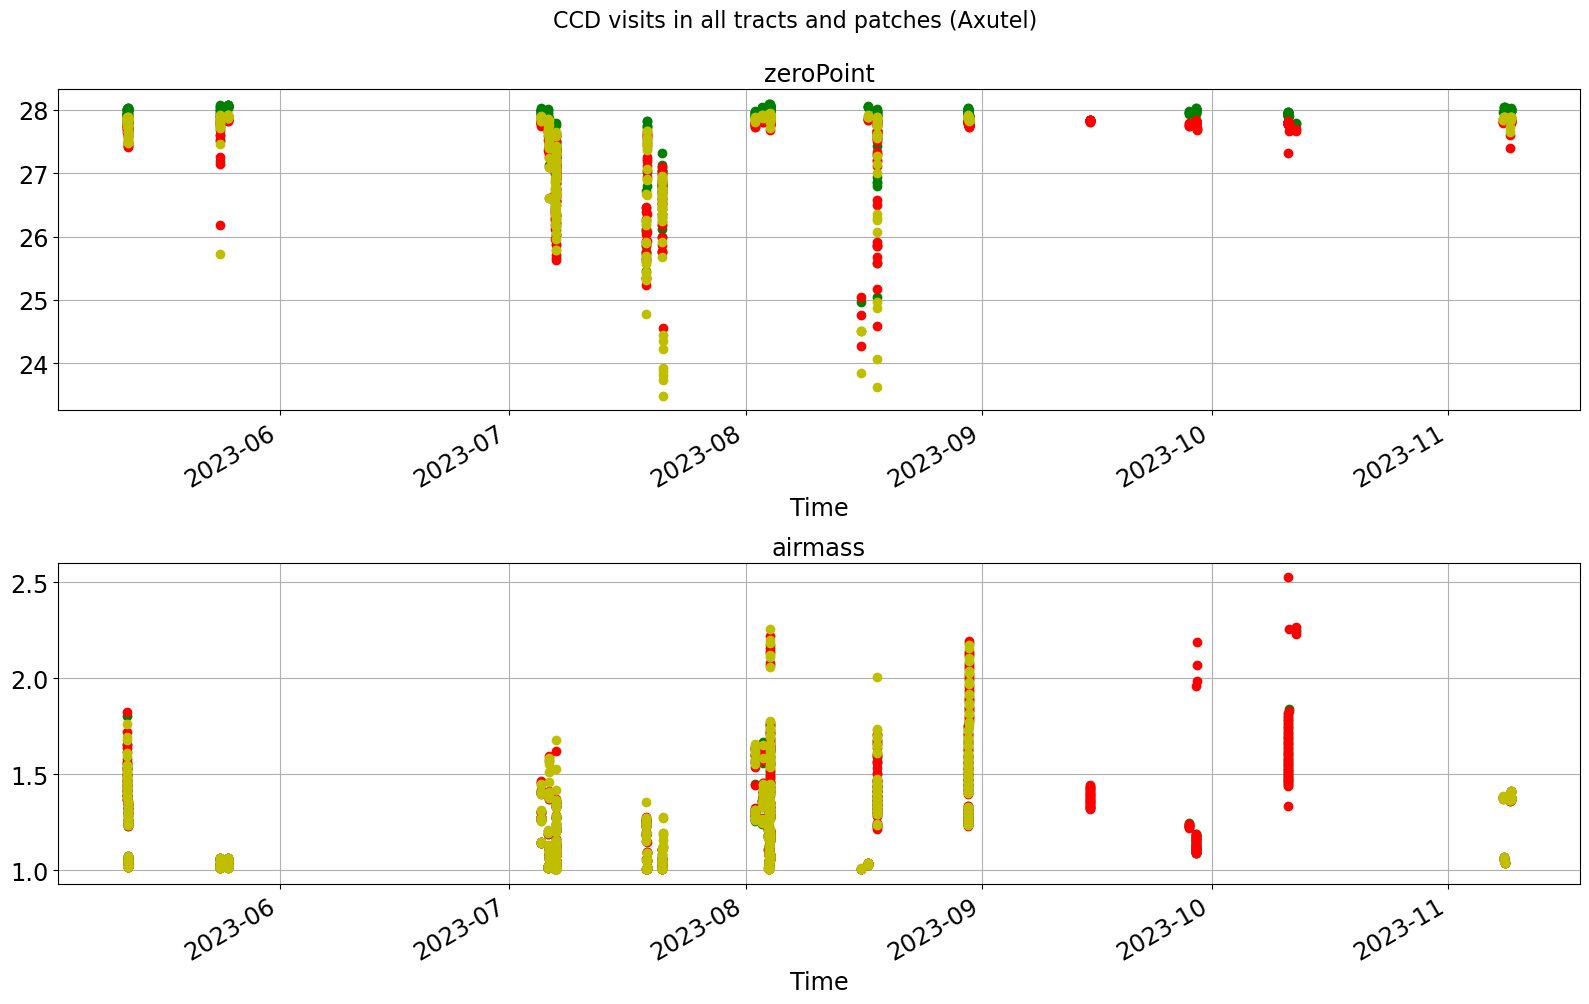

In [46]:
fig,(ax1,ax2) = plt.subplots(2,1,figsize=(16,10))

df[df["band"]=="g"].plot(x="Time",y="zeroPoint",marker='o',c="g",lw=0.0,ax=ax1,grid=True,legend=False)
df[df["band"]=="r"].plot(x="Time",y="zeroPoint",marker='o',c="r",lw=0.0,ax=ax1,grid=True,legend=False)
df[df["band"]=="i"].plot(x="Time",y="zeroPoint",marker='o',c="y",lw=0.0,ax=ax1,grid=True,legend=False)
ax1.set_title("zeroPoint")


df[df["band"]=="g"].plot(x="Time",y="airmass",marker='o',c="g",lw=0.0,ax=ax2,grid=True,legend=False)
df[df["band"]=="r"].plot(x="Time",y="airmass",marker='o',c="r",lw=0.0,ax=ax2,grid=True,legend=False)
df[df["band"]=="i"].plot(x="Time",y="airmass",marker='o',c="y",lw=0.0,ax=ax2,grid=True,legend=False)
ax2.set_title("airmass")


#df.plot(x="Time",y="coord_dec",marker='o',c="g",lw=0.0,ax=ax2,grid=True)
plt.suptitle(suptitle,y=1.0,fontsize=16)
plt.tight_layout()

## Plot number of visit per day

### Plot number of visit per day 

/tmp/ipykernel_44131/1158846257.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  ccd_visit_table.plot.hist(column=["nightObs"], by="band", bins=200,grid=True,ax=ax,legend=False)


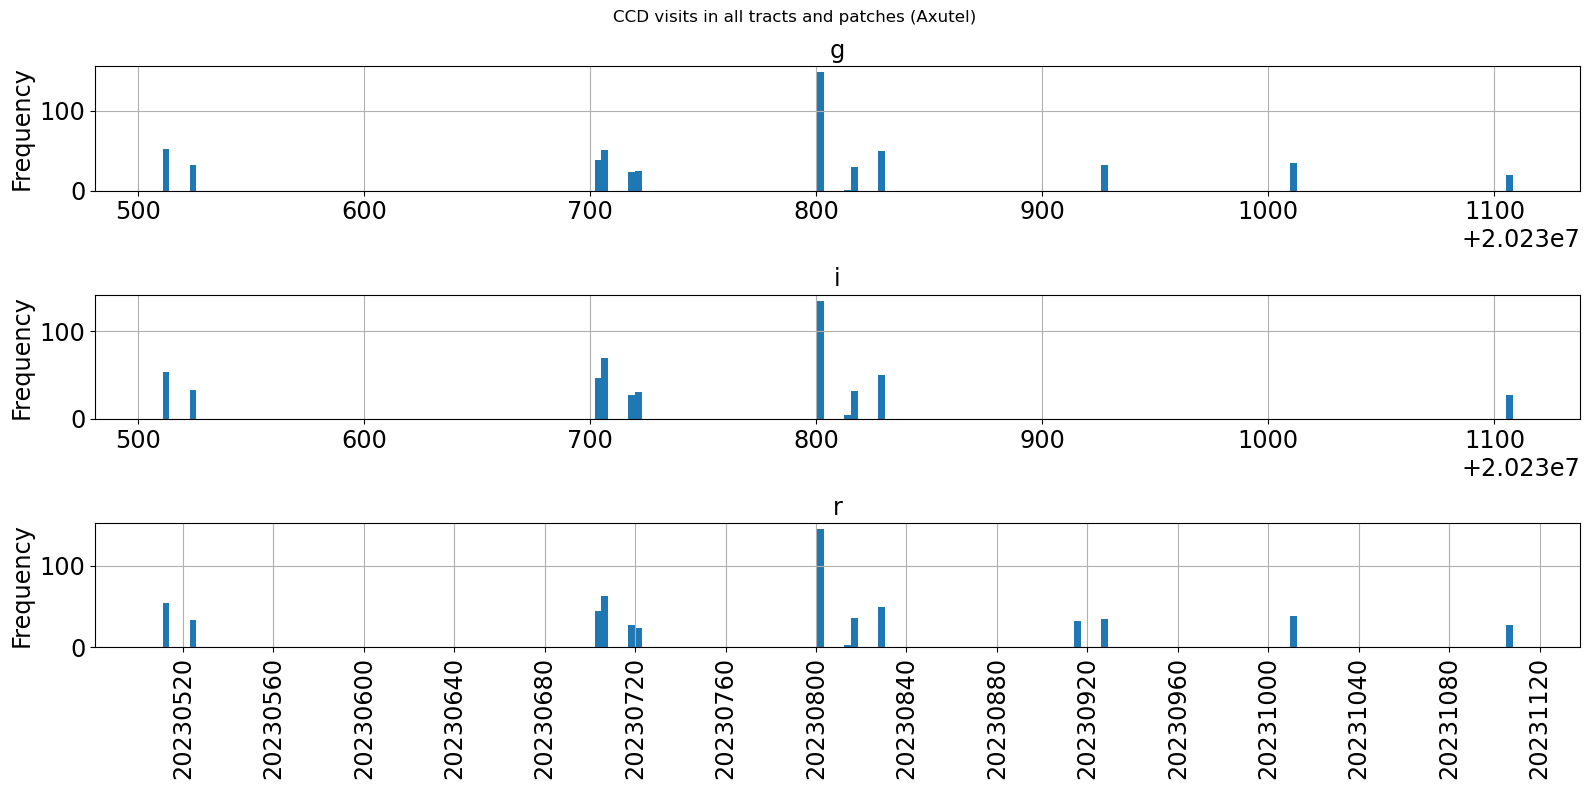

In [47]:
import matplotlib.ticker
fig,ax = plt.subplots(1,1,figsize=(16,8))
ccd_visit_table.plot.hist(column=["nightObs"], by="band", bins=200,grid=True,ax=ax,legend=False)


# plot x axis as an int
locator = matplotlib.ticker.MultipleLocator(2)

plt.gca().xaxis.set_major_locator(locator)
formatter = matplotlib.ticker.StrMethodFormatter("{x:.0f}")
plt.gca().xaxis.set_major_formatter(formatter)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(20))
plt.xticks(rotation=90)

plt.suptitle(suptitle)
plt.tight_layout()

In [48]:
ccd_visit_table_counts_byband = ccd_visit_table.groupby(['nightObs','band']).count()["visitId"]
ccd_visit_table_counts_byband.name = "countVisitperBandperNight" 
ccd_visit_table_counts_byband

nightObs  band
20230511  g        52
          i        54
          r        54
20230523  g        13
          i        13
          r        14
20230524  g        19
          i        20
          r        19
20230704  g        17
          i        18
          r        18
20230705  g        21
          i        29
          r        26
20230706  g        51
          i        69
          r        63
20230718  g        23
          i        27
          r        27
20230720  g        24
          i        31
          r        24
20230801  g        14
          i        12
          r        13
20230802  g        22
          i        15
          r        18
20230803  g       112
          i       108
          r       114
20230815  g         1
          i         4
          r         3
20230816  g         4
          i         4
          r         4
20230817  g        26
          i        28
          r        32
20230829  g        50
          i        50
          r      

In [49]:
ccd_visit_table_counts = ccd_visit_table.groupby(['nightObs']).count()["visitId"]
ccd_visit_table_counts.name = "countVisitperNight" 
ccd_visit_table_counts

nightObs
20230511    160
20230523     40
20230524     58
20230704     53
20230705     76
20230706    183
20230718     77
20230720     79
20230801     39
20230802     55
20230803    334
20230815      8
20230816     12
20230817     86
20230829    150
20230914     32
20230927     10
20230928     57
20231010     69
20231011      4
20231107     26
20231108     47
Name: countVisitperNight, dtype: int64

## Loop on all nights

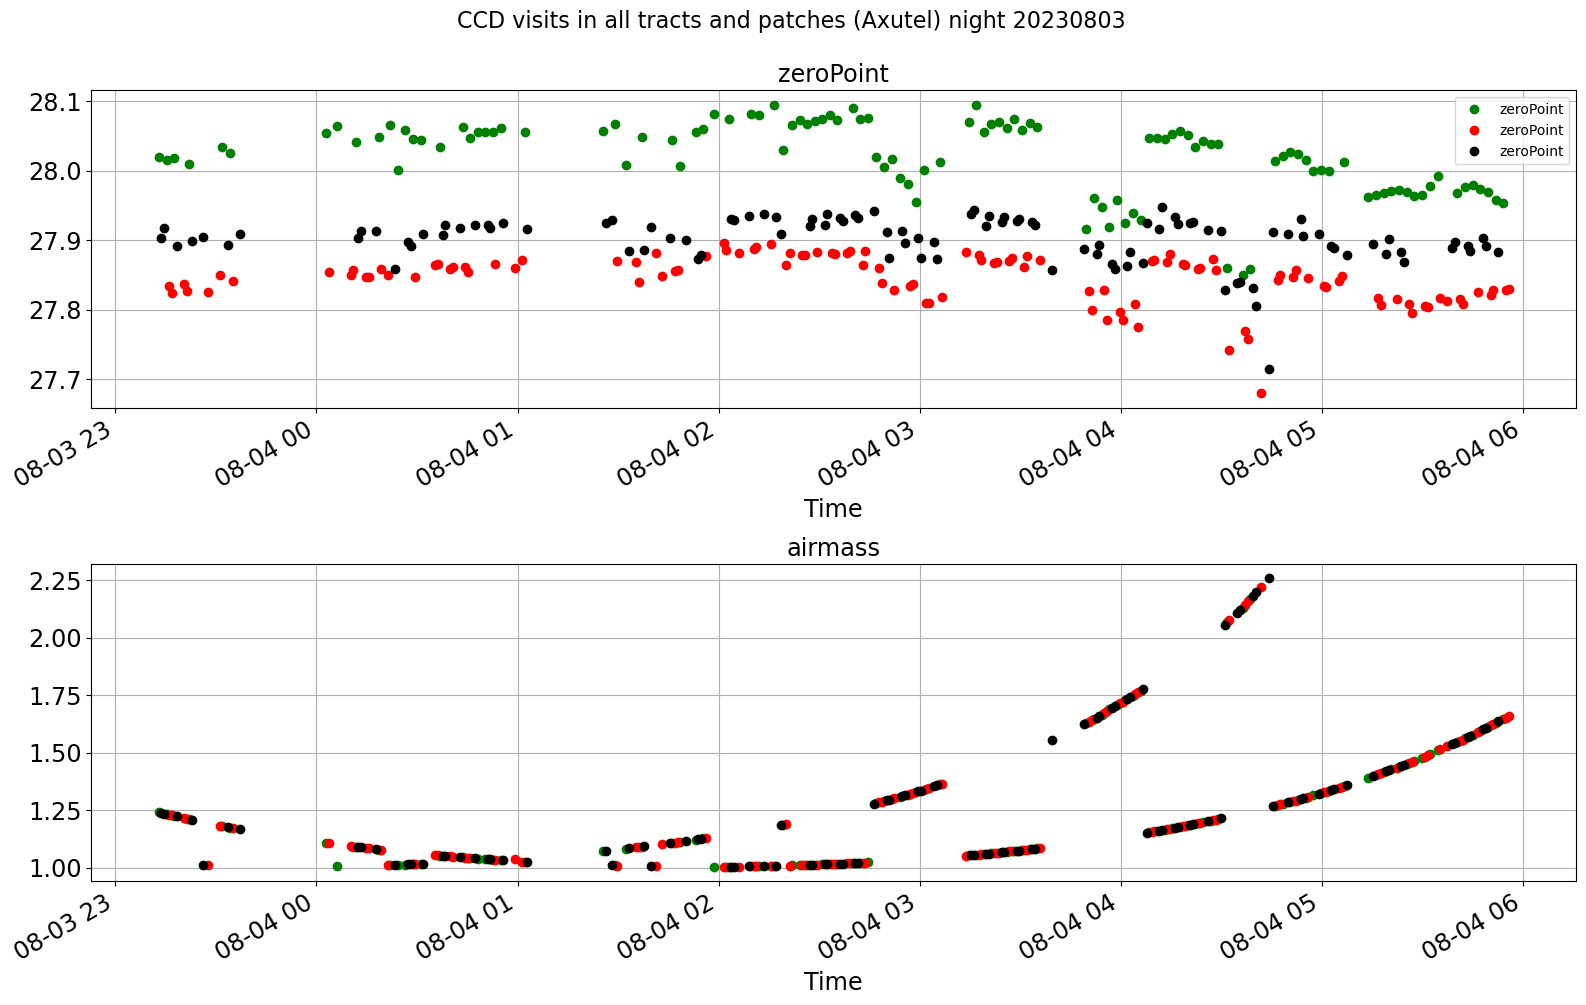

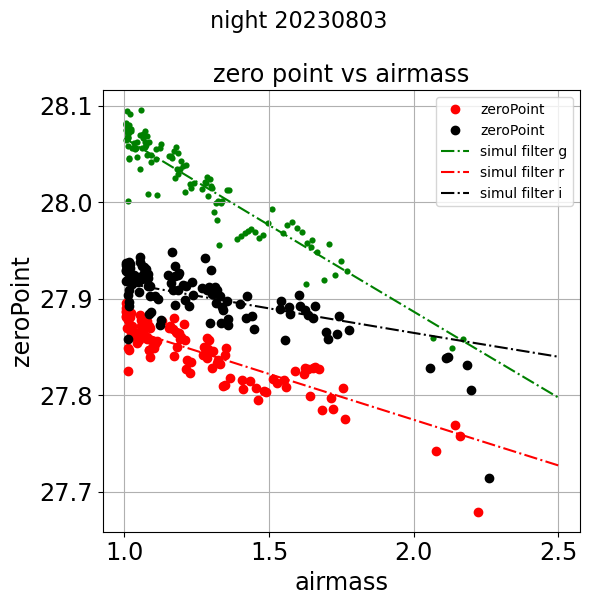

In [50]:
all_night_obs = ccd_visit_table['nightObs'].unique()
all_night_obs = [20230803]
for nightObs_selected in all_night_obs:
    ccd_visit_table_nightsel = ccd_visit_table[ccd_visit_table.nightObs == nightObs_selected]
    ccd_visit_table_nightselcount_byband = ccd_visit_table_nightsel.groupby(['band']).count()["visitId"]
    ccd_visit_table_nightselcountsum = ccd_visit_table_nightselcount_byband.sum() 
    df = ccd_visit_table_nightsel

    fig,(ax1,ax2) = plt.subplots(2,1,figsize=(16,10))
    df[df["band"]=="g"].plot(x="Time",y="zeroPoint",marker='o',c="g",lw=0.0,ax=ax1,grid=True,legend="auxtel g filter")
    df[df["band"]=="r"].plot(x="Time",y="zeroPoint",marker='o',c="r",lw=0.0,ax=ax1,grid=True,legend="auxtel r filter")
    df[df["band"]=="i"].plot(x="Time",y="zeroPoint",marker='o',c="k",lw=0.0,ax=ax1,grid=True,legend="auxtel i filter")
    ax1.set_title("zeroPoint")

    df[df["band"]=="g"].plot(x="Time",y="airmass",marker='o',c="g",lw=0.0,ax=ax2,grid=True,legend=False)
    df[df["band"]=="r"].plot(x="Time",y="airmass",marker='o',c="r",lw=0.0,ax=ax2,grid=True,legend=False)
    df[df["band"]=="i"].plot(x="Time",y="airmass",marker='o',c="k",lw=0.0,ax=ax2,grid=True,legend=False)
    ax2.set_title("airmass")
    plt.suptitle(suptitle + f" night {nightObs_selected}",y=1.0,fontsize=16)
    plt.tight_layout()
    plt.show()

    fig,ax = plt.subplots(1,1,figsize=(6,6))

    df[df["band"]=="g"].plot.scatter(x="airmass",y="zeroPoint",marker='o',c="g",lw=0.0,ax=ax,grid=True,legend="auxtel g filter")
    df[df["band"]=="r"].plot(x="airmass",y="zeroPoint",marker='o',c="r",lw=0.0,ax=ax,grid=True,legend="auxtel r filter")
    df[df["band"]=="i"].plot(x="airmass",y="zeroPoint",marker='o',c="k",lw=0.0,ax=ax,grid=True,legend="auxtel i filter")
    ax.set_title("zero point vs airmass")

    #  # np.array([-0.17429742,-0.39848897,-0.38915855 ])
    ax.plot(all_am,pc.allcollperfilter['g']['ZPT_nonstd']-0.17429742,'-.g',label="simul filter g")
    ax.plot(all_am,pc.allcollperfilter['r']['ZPT_nonstd']-0.39848897,'-.r',label="simul filter r")
    ax.plot(all_am,pc.allcollperfilter['i']['ZPT_nonstd']-0.38915855,'-.k',label="simul filter i")
    ax.legend()

    plt.suptitle(f" night {nightObs_selected}",y=1.0,fontsize=16)
    plt.tight_layout()
    plt.show()



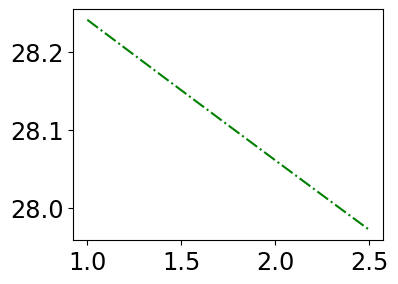

In [51]:
plt.plot(all_am,pc.allcollperfilter['g']['ZPT_nonstd'],'-.g',label="simul filter g")

## Derive the polynom of the models

In [52]:
Z_g = np.polyfit(all_am,pc.allcollperfilter['g']['ZPT_nonstd'], 1)

In [53]:
Z_r = np.polyfit(all_am,pc.allcollperfilter['r']['ZPT_nonstd'], 1)

In [54]:
Z_i = np.polyfit(all_am,pc.allcollperfilter['i']['ZPT_nonstd'], 1)

In [55]:
pol_g = np.poly1d(Z_g)
pol_r = np.poly1d(Z_r)
pol_i = np.poly1d(Z_i)

In [57]:
from scipy.optimize import curve_fit

In [58]:
def func_g(x, k):
    return pol_g(x) + k

In [59]:
def func_r(x, k):
    return pol_r(x) + k

In [60]:
def func_i(x, k):
    return pol_i(x) + k

In [65]:
Xdata_g  = df[df["band"]=="g"]["airmass"].values
Ydata_g = df[df["band"]=="g"]["zeroPoint"].values
popt_g, pcov_g = curve_fit(func_g, Xdata_g, Ydata_g)
popt_g

array([-0.17429742])

In [66]:
Xdata_r  = df[df["band"]=="r"]["airmass"].values
Ydata_r  = df[df["band"]=="r"]["zeroPoint"].values
popt_r, pcov_r = curve_fit(func_r, Xdata_r, Ydata_r)
popt_r

array([-0.39848897])

In [67]:
Xdata_i  = df[df["band"]=="i"]["airmass"].values
Ydata_i  = df[df["band"]=="i"]["zeroPoint"].values
popt_i, pcov_i = curve_fit(func_i, Xdata_i, Ydata_i)
popt_i

array([-0.38915855])

In [64]:
np.array([-0.17429742,-0.39848897,-0.38915855 ])

array([-0.17429742, -0.39848897, -0.38915855])

In [81]:
DeltaZP_g = (Ydata_g - func_g(Xdata_g,popt_g[0]))*1000
DeltaZP_r = (Ydata_r - func_r(Xdata_r,popt_r[0]))*1000
DeltaZP_i = (Ydata_i - func_i(Xdata_i,popt_i[0]))*1000
std_g = np.std(DeltaZP_g)
std_r = np.std(DeltaZP_r)
std_i = np.std(DeltaZP_i)

In [94]:
textstr_g = r'$\sigma=%.1f$ mmag' % (std_g, )
textstr_r = r'$\sigma=%.1f$ mmag' % (std_r, )
textstr_i = r'$\sigma=%.1f$ mmag' % (std_i, )

Text(0.5, 1.0, ' night 20230803')

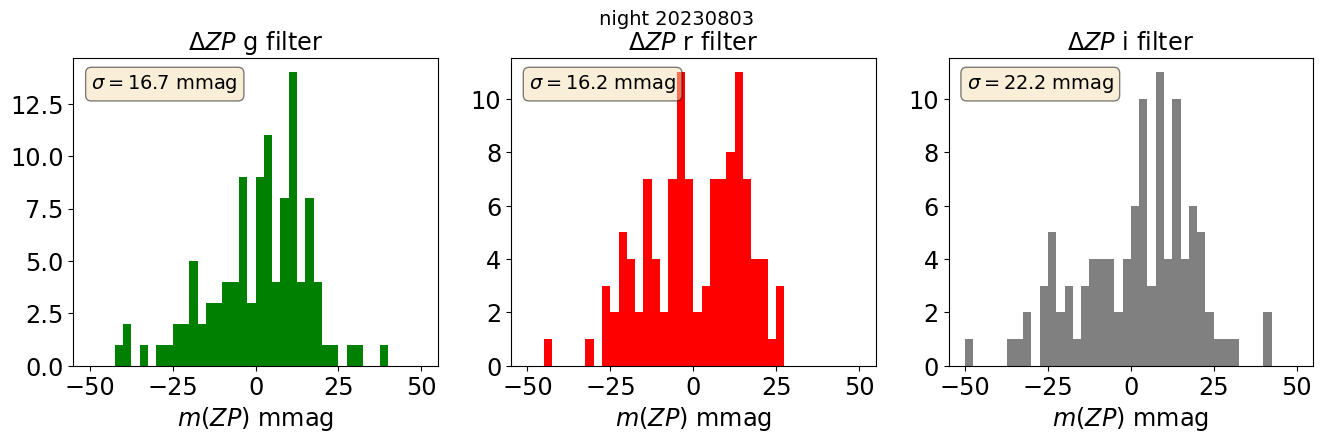

In [97]:
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(16,4))
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

ax1.hist(DeltaZP_g,bins=40,range=(-50.,50.),facecolor="g")
ax1.set_title("$\Delta ZP$ g filter")
ax1.set_xlabel("$m(ZP)$ mmag")
ax1.text(0.05, 0.95, textstr_g, transform=ax1.transAxes, fontsize=14,verticalalignment='top', bbox=props)
ax2.hist(DeltaZP_r,bins=40,range=(-50.,50.),facecolor="r")
ax2.set_title("$\Delta ZP$ r filter")
ax2.set_xlabel("$m(ZP)$ mmag")
ax2.text(0.05, 0.95, textstr_r, transform=ax2.transAxes, fontsize=14,verticalalignment='top', bbox=props)
ax3.hist(DeltaZP_i,bins=40,range=(-50.,50.),facecolor="grey")
ax3.set_title("$\Delta ZP$ i filter")
ax3.set_xlabel("$m(ZP)$ mmag")
ax3.text(0.05, 0.95, textstr_i, transform=ax3.transAxes, fontsize=14,verticalalignment='top', bbox=props)
plt.suptitle(f" night {nightObs_selected}",y=1.0,fontsize=14)